# Workbook 2

## This second workbook is to revisit the dataframe in whole and re-evaluate features to better feature enginner the and or clean them to improve model performance.

In [1]:
# imports
import warnings

warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from env import get_connection

# local
from wrangle import acquire_zillow, clean_zillow, wrangle_zillow, train_val_test, xy_split
from explore import dist_of_nums, plot_variable_pairs, plot_categorical_and_continuous_vars, evaluate_correlation
from evaluate import plot_residuals, regression_errors, baseline_mean_errors, better_than_baseline
from model import eval_model, train_model, train_and_evaluate_model, scale_data
from math import sqrt

In [2]:
# Constants
filename = 'zillow_data2.csv'

# Acquire data.
# ----------------------ACQUIRE FUNCTION---------------------------------
def acquire_zillow():

    if os.path.isfile(filename):
        
        return pd.read_csv(filename)
        
    else: 

        query = '''
                SELECT p17.parcelid, latitude, longitude, lotsizesquarefeet, regionidcounty, regionidcity, regionidzip, propertycountylandusecode, propertyzoningdesc, -- parcel information
                bathroomcnt, bedroomcnt, calculatedbathnbr, fullbathcnt, calculatedfinishedsquarefeet, basementsqft, finishedsquarefeet12, finishedsquarefeet15, finishedsquarefeet50, fips, roomcnt, numberofstories, yearbuilt, -- property characteristics
                plu.propertylandusetypeid, airconditioningtypeid, buildingqualitytypeid, heatingorsystemtypeid, architecturalstyletypeid, buildingclasstypeid, decktypeid, typeconstructiontypeid, unitcnt, -- building information
                garagecarcnt, garagetotalsqft, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7, fireplacecnt, fireplaceflag, hashottuborspa, yardbuildingsqft17, yardbuildingsqft26, threequarterbathnbr, -- additional property features
                taxvaluedollarcnt, taxdelinquencyflag, taxdelinquencyyear, -- allowed tax info
                rawcensustractandblock, censustractandblock -- census information
                
                FROM properties_2017 AS p17
                
                LEFT JOIN predictions_2017 AS pr17 ON p17.parcelid = pr17.parcelid
                
                LEFT JOIN propertylandusetype AS plu ON p17.propertylandusetypeid = plu.propertylandusetypeid
                
                WHERE plu.propertylandusetypeid = 261 AND YEAR(pr17.transactiondate) = 2017; -- 'Single Family Residential' and transactions in 2017017; -- 'Single Family Residential' and transactions in 2017
                '''

        url = get_connection('zillow')
                
        df = pd.read_sql(query, url)

        # # save to csv
        # df.to_csv(filename,index=False)

        return df 

In [3]:
df = acquire_zillow()
df.head()

,parcelid,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidcity,regionidzip,propertycountylandusecode,propertyzoningdesc,bathroomcnt,...,fireplaceflag,hashottuborspa,yardbuildingsqft17,yardbuildingsqft26,threequarterbathnbr,taxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,rawcensustractandblock,censustractandblock
0,14297519,33634931.0,-117869207.0,4506.0,1286.0,53571.0,96978.0,122,None,3.5,...,NaN,NaN,NaN,NaN,1.0,1023282.0,None,NaN,6.059063e+07,6.059063e+13
1,17052889,34449266.0,-119281531.0,12647.0,2061.0,13091.0,97099.0,1110,None,1.0,...,NaN,NaN,NaN,NaN,NaN,464000.0,None,NaN,6.111001e+07,6.111001e+13
2,14186244,33886168.0,-117823170.0,8432.0,1286.0,21412.0,97078.0,122,None,2.0,...,NaN,NaN,NaN,NaN,NaN,564778.0,None,NaN,6.059022e+07,6.059022e+13
3,12177905,34245180.0,-118240722.0,13038.0,3101.0,396551.0,96330.0,0101,LCR110000*,3.0,...,NaN,NaN,NaN,NaN,NaN,145143.0,None,NaN,6.037300e+07,6.037300e+13
4,12095076,34145202.0,-118179824.0,63000.0,3101.0,47019.0,96293.0,0101,PSR2,3.0,...,NaN,NaN,NaN,NaN,NaN,773303.0,None,NaN,6.037461e+07,6.037461e+13


In [4]:
# checking all nulls in df
df.isna().sum()

parcelid                            0
latitude                            0
longitude                           0
lotsizesquarefeet                 369
regionidcounty                      0
regionidcity                     1037
regionidzip                        26
propertycountylandusecode           0
propertyzoningdesc              18593
bathroomcnt                         0
bedroomcnt                          0
calculatedbathnbr                 137
fullbathcnt                       137
calculatedfinishedsquarefeet       82
basementsqft                    52394
finishedsquarefeet12              247
finishedsquarefeet15            52441
finishedsquarefeet50            48060
fips                                0
roomcnt                             0
numberofstories                 37880
yearbuilt                         116
propertylandusetypeid               0
airconditioningtypeid           38803
buildingqualitytypeid           18701
heatingorsystemtypeid           18506
architectura

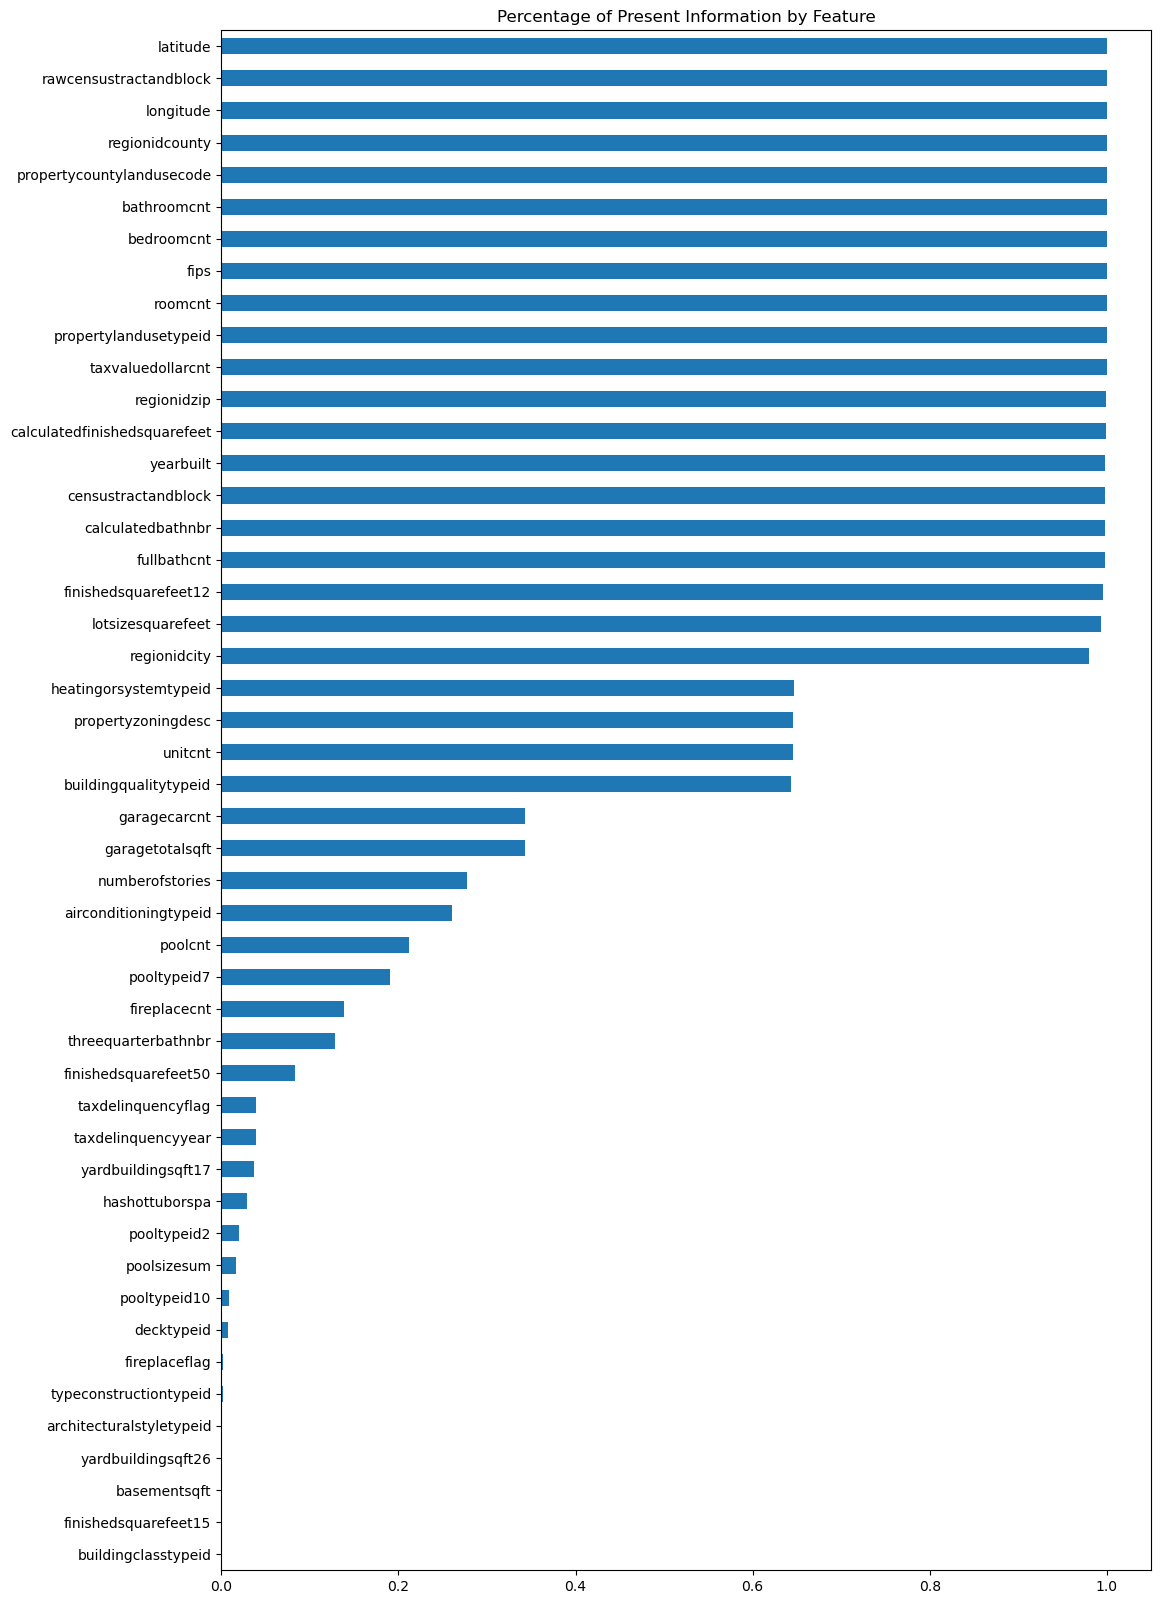

In [5]:
# displaying feature percentages
plt.figure(figsize=(12,20))
df.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = True).plot(kind = 'barh')
plt.title('Percentage of Present Information by Feature')
plt.show()

In [6]:
# dropping parcelid and checking for percentage of what is present in less than 1% of homes.
# mostly all of them are not 1% percent so we may have to drop the ones that have many nulls.
# but before we do so we can clean some data and impute/fill values for some of these features that are nor represented well in the raw data.
df.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)

latitude                        1.000000
fips                            1.000000
rawcensustractandblock          1.000000
regionidcounty                  1.000000
propertycountylandusecode       1.000000
longitude                       1.000000
bathroomcnt                     1.000000
bedroomcnt                      1.000000
propertylandusetypeid           1.000000
roomcnt                         1.000000
taxvaluedollarcnt               0.999981
regionidzip                     0.999504
calculatedfinishedsquarefeet    0.998436
yearbuilt                       0.997788
censustractandblock             0.997655
fullbathcnt                     0.997388
calculatedbathnbr               0.997388
finishedsquarefeet12            0.995290
lotsizesquarefeet               0.992964
regionidcity                    0.980225
heatingorsystemtypeid           0.647108
propertyzoningdesc              0.645449
unitcnt                         0.645430
buildingqualitytypeid           0.643390
garagecarcnt    

## pool features edits

In [7]:
# 0 pools
df.poolcnt.fillna(0, inplace = True)

In [8]:
# 0 hot tubs or spa
df.hashottuborspa.fillna(0, inplace = True)

In [9]:
# convert True to 1
df.hashottuborspa.replace(to_replace = True, value = 1,inplace = True)

In [10]:
# checking feature column
print(df['hashottuborspa'].value_counts())

0.0    50926
1.0     1515
Name: hashottuborspa, dtype: int64


In [11]:
# setting properties that have a pool but no info on poolsize equal to the median poolsize value
df.loc[df.poolcnt == 1, 'poolsizesum'] = df.loc[df.poolcnt == 1, 'poolsizesum'].fillna(df[df.poolcnt == 1].poolsizesum.median())

# 0 pools = 0 sqft of poolsdf.loc[df.poolcnt == 0, 'poolsizesum'] = 0

# 0 pools with a spa/hot tub
df.pooltypeid2.fillna(0, inplace = True)

# 0 pools without a hot tub
df.pooltypeid7.fillna(0, inplace = True)

# Drop redundant featire
df.drop('pooltypeid10', axis=1, inplace=True)


In [12]:
# checked all of the following and they have been fileld with values
df.hashottuborspa.value_counts()

0.0    50926
1.0     1515
Name: hashottuborspa, dtype: int64

In [13]:
df.poolcnt.value_counts()

0.0    41345
1.0    11096
Name: poolcnt, dtype: int64

In [14]:
df.pooltypeid2.value_counts() 

0.0    51370
1.0     1071
Name: pooltypeid2, dtype: int64

In [15]:
df.pooltypeid7.value_counts()

0.0    42432
1.0    10009
Name: pooltypeid7, dtype: int64

In [16]:
df.poolsizesum.isna().sum()

41345

## Firelpace feature edits

In [17]:
print(df['fireplaceflag'].value_counts())

1.0    81
Name: fireplaceflag, dtype: int64


In [18]:
# If fireplaceflag is True and fireplacecnt is NaN, "fireplacecnt" will be equal to the median value of 1.
df.loc[(df['fireplaceflag'] == True) & (df['fireplacecnt'].isnull()), ['fireplacecnt']] = 1

In [19]:
# If fireplacecnt is NaN, replace with 0
df.fireplacecnt.fillna(0,inplace = True)

In [20]:
# If fireplacecnt is 1 or larger fireplaceflag is NaN, we will set fireplaceflag to True.
df.loc[(df['fireplacecnt'] >= 1.0) & (df['fireplaceflag'].isnull()), ['fireplaceflag']] = True
df.fireplaceflag.fillna(0,inplace = True)

In [21]:
# printed output
print (df['fireplaceflag'].value_counts())

0       45117
True     7324
Name: fireplaceflag, dtype: int64


In [22]:
# changed True value to 1
df.fireplaceflag.replace(to_replace = True, value = 1, inplace = True)

In [23]:
# printed output
print (df['fireplaceflag'].value_counts())

0    45117
1     7324
Name: fireplaceflag, dtype: int64


## Garage feature edits

- garagecarcnt and garagetotalsqft have nanas that can be replace with 0 to fix if a home has a garage and if there is a value associated with it.

-  There are some type II errors , we donl't want our data to show garagecarcnt with NaN but have some sq ft value.

In [24]:
# filled features garage features
df.garagecarcnt.fillna(0,inplace = True)
df.garagetotalsqft.fillna(0,inplace = True)

In [25]:
# checking feature column
df.garagecarcnt.value_counts()

0.0     34491
2.0     14802
1.0      2202
3.0       621
4.0       254
5.0        45
6.0        13
7.0         3
10.0        3
8.0         2
9.0         2
11.0        1
13.0        1
14.0        1
Name: garagecarcnt, dtype: int64

In [26]:
# checking feature column
df.garagetotalsqft.value_counts()

0.0       34621
400.0       788
441.0       678
462.0       660
360.0       648
          ...  
275.0         1
1056.0        1
261.0         1
1155.0        1
957.0         1
Name: garagetotalsqft, Length: 839, dtype: int64

## Tax delinquincy feature edits

In [27]:
# checking tax deliquincy feature column
print (df['taxdelinquencyflag'].value_counts())

Y    2079
Name: taxdelinquencyflag, dtype: int64


In [28]:
# replace Nan with 0 and 'Y' to 1
df.taxdelinquencyflag.fillna(0, inplace = True)
df.taxdelinquencyflag.replace(to_replace = 'Y', value = 1, inplace = True)

In [29]:
# checking tax deliquincy feature column
print (df['taxdelinquencyflag'].value_counts())

0    50362
1     2079
Name: taxdelinquencyflag, dtype: int64


In [30]:
# filleddelinquencyyear column tax
df.drop('taxdelinquencyyear', axis = 1, inplace = True)

## other features

In [31]:
# filling basementsqft Nan values with 0
df.basementsqft.fillna(0, inplace = True)

In [32]:
# checking for nulls
df['yardbuildingsqft26'].isna().sum()

52378

In [33]:
# filling yardbuildingsqft26 Nan values with 0
df.yardbuildingsqft26.fillna(0, inplace = True)

In [34]:
df['yardbuildingsqft26'].isna().sum()

0

In [35]:
# looking at column
df.architecturalstyletypeid.value_counts()

7.0     62
3.0      3
2.0      2
21.0     2
8.0      1
Name: architecturalstyletypeid, dtype: int64

In [36]:
# dropping feature columns because not enough data to use it although to include in predicting price it would be cool
df.drop('architecturalstyletypeid', axis = 1, inplace = True)

In [37]:
# dropping feature columns because not enough data to use a column with type of material the property is made of.
df.drop('typeconstructiontypeid', axis = 1, inplace = True)

In [38]:
# # dropping feature columns because its almost the same as calculated square foot column
# df.drop('finishedsquarefeet12', axis = 1, inplace = True)

In [39]:
# check df
df.head()

,parcelid,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidcity,regionidzip,propertycountylandusecode,propertyzoningdesc,bathroomcnt,...,fireplacecnt,fireplaceflag,hashottuborspa,yardbuildingsqft17,yardbuildingsqft26,threequarterbathnbr,taxvaluedollarcnt,taxdelinquencyflag,rawcensustractandblock,censustractandblock
0,14297519,33634931.0,-117869207.0,4506.0,1286.0,53571.0,96978.0,122,None,3.5,...,0.0,0,0.0,NaN,0.0,1.0,1023282.0,0,6.059063e+07,6.059063e+13
1,17052889,34449266.0,-119281531.0,12647.0,2061.0,13091.0,97099.0,1110,None,1.0,...,1.0,1,0.0,NaN,0.0,NaN,464000.0,0,6.111001e+07,6.111001e+13
2,14186244,33886168.0,-117823170.0,8432.0,1286.0,21412.0,97078.0,122,None,2.0,...,0.0,0,0.0,NaN,0.0,NaN,564778.0,0,6.059022e+07,6.059022e+13
3,12177905,34245180.0,-118240722.0,13038.0,3101.0,396551.0,96330.0,0101,LCR110000*,3.0,...,0.0,0,0.0,NaN,0.0,NaN,145143.0,0,6.037300e+07,6.037300e+13
4,12095076,34145202.0,-118179824.0,63000.0,3101.0,47019.0,96293.0,0101,PSR2,3.0,...,0.0,0,0.0,NaN,0.0,NaN,773303.0,0,6.037461e+07,6.037461e+13


In [40]:
# dropping feature column missing way too much information
df.drop('buildingclasstypeid', axis = 1, inplace = True)

In [41]:
# check shape and not null mean values of df.
df.shape
df.notnull().mean().sort_values(ascending = False)

parcelid                        1.000000
fips                            1.000000
rawcensustractandblock          1.000000
taxdelinquencyflag              1.000000
yardbuildingsqft26              1.000000
hashottuborspa                  1.000000
fireplaceflag                   1.000000
fireplacecnt                    1.000000
pooltypeid7                     1.000000
pooltypeid2                     1.000000
poolcnt                         1.000000
garagetotalsqft                 1.000000
garagecarcnt                    1.000000
latitude                        1.000000
roomcnt                         1.000000
propertylandusetypeid           1.000000
bedroomcnt                      1.000000
bathroomcnt                     1.000000
longitude                       1.000000
basementsqft                    1.000000
regionidcounty                  1.000000
propertycountylandusecode       1.000000
taxvaluedollarcnt               0.999981
regionidzip                     0.999504
calculatedfinish

In [42]:
# checking deck type id column
df.decktypeid.value_counts()

66.0    389
Name: decktypeid, dtype: int64

- can change decktypeid to 1 and 0 here too


In [43]:
# NaN to 0
df.decktypeid.fillna(0, inplace = True)

# convert 66.0 to 1 
df.decktypeid.replace(to_replace = 66.0, value = 1, inplace = True)

In [44]:
# checking df
df.head(3)

,parcelid,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidcity,regionidzip,propertycountylandusecode,propertyzoningdesc,bathroomcnt,...,fireplacecnt,fireplaceflag,hashottuborspa,yardbuildingsqft17,yardbuildingsqft26,threequarterbathnbr,taxvaluedollarcnt,taxdelinquencyflag,rawcensustractandblock,censustractandblock
0,14297519,33634931.0,-117869207.0,4506.0,1286.0,53571.0,96978.0,122,None,3.5,...,0.0,0,0.0,NaN,0.0,1.0,1023282.0,0,6.059063e+07,6.059063e+13
1,17052889,34449266.0,-119281531.0,12647.0,2061.0,13091.0,97099.0,1110,None,1.0,...,1.0,1,0.0,NaN,0.0,NaN,464000.0,0,6.111001e+07,6.111001e+13
2,14186244,33886168.0,-117823170.0,8432.0,1286.0,21412.0,97078.0,122,None,2.0,...,0.0,0,0.0,NaN,0.0,NaN,564778.0,0,6.059022e+07,6.059022e+13


In [45]:
df.head()

,parcelid,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidcity,regionidzip,propertycountylandusecode,propertyzoningdesc,bathroomcnt,...,fireplacecnt,fireplaceflag,hashottuborspa,yardbuildingsqft17,yardbuildingsqft26,threequarterbathnbr,taxvaluedollarcnt,taxdelinquencyflag,rawcensustractandblock,censustractandblock
0,14297519,33634931.0,-117869207.0,4506.0,1286.0,53571.0,96978.0,122,None,3.5,...,0.0,0,0.0,NaN,0.0,1.0,1023282.0,0,6.059063e+07,6.059063e+13
1,17052889,34449266.0,-119281531.0,12647.0,2061.0,13091.0,97099.0,1110,None,1.0,...,1.0,1,0.0,NaN,0.0,NaN,464000.0,0,6.111001e+07,6.111001e+13
2,14186244,33886168.0,-117823170.0,8432.0,1286.0,21412.0,97078.0,122,None,2.0,...,0.0,0,0.0,NaN,0.0,NaN,564778.0,0,6.059022e+07,6.059022e+13
3,12177905,34245180.0,-118240722.0,13038.0,3101.0,396551.0,96330.0,0101,LCR110000*,3.0,...,0.0,0,0.0,NaN,0.0,NaN,145143.0,0,6.037300e+07,6.037300e+13
4,12095076,34145202.0,-118179824.0,63000.0,3101.0,47019.0,96293.0,0101,PSR2,3.0,...,0.0,0,0.0,NaN,0.0,NaN,773303.0,0,6.037461e+07,6.037461e+13


In [46]:
df.columns.to_list()

['parcelid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'regionidcounty',
 'regionidcity',
 'regionidzip',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'fullbathcnt',
 'calculatedfinishedsquarefeet',
 'basementsqft',
 'finishedsquarefeet12',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'fips',
 'roomcnt',
 'numberofstories',
 'yearbuilt',
 'propertylandusetypeid',
 'airconditioningtypeid',
 'buildingqualitytypeid',
 'heatingorsystemtypeid',
 'decktypeid',
 'unitcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'poolcnt',
 'poolsizesum',
 'pooltypeid2',
 'pooltypeid7',
 'fireplacecnt',
 'fireplaceflag',
 'hashottuborspa',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'threequarterbathnbr',
 'taxvaluedollarcnt',
 'taxdelinquencyflag',
 'rawcensustractandblock',
 'censustractandblock']

## Calculated area

In [47]:
df[['calculatedfinishedsquarefeet','numberofstories','lotsizesquarefeet']]

,calculatedfinishedsquarefeet,numberofstories,lotsizesquarefeet
0,3100.0,NaN,4506.0
1,1465.0,1.0,12647.0
2,1243.0,1.0,8432.0
3,2376.0,NaN,13038.0
4,2962.0,NaN,63000.0
...,...,...,...
52436,1633.0,NaN,4630.0
52437,1286.0,NaN,47405.0
52438,1612.0,1.0,12105.0
52439,1032.0,NaN,5074.0


In [48]:
# Replace NaN calculatedfinishedsquarefeet values with mean.
df['calculatedfinishedsquarefeet'].fillna((df['calculatedfinishedsquarefeet'].mean()), inplace=True)

In [49]:
# Replace NaN finishedsquarefeet15 values with calculatedfinishedsquarefeet.
df.loc[df['finishedsquarefeet15'].isnull(),'finishedsquarefeet15'] = df['calculatedfinishedsquarefeet']

In [50]:
# Replace NaN finishedsquarefeet12 values with calculatedfinishedsquarefeet.
df.loc[df['finishedsquarefeet12'].isnull(),'finishedsquarefeet12'] = df['calculatedfinishedsquarefeet']

In [51]:
# fill in numberofstories Nan
df.numberofstories.fillna(1,inplace = True)

In [52]:
df.shape
df.notnull().mean().sort_values(ascending = False)

parcelid                        1.000000
pooltypeid2                     1.000000
numberofstories                 1.000000
latitude                        1.000000
decktypeid                      1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
poolcnt                         1.000000
pooltypeid7                     1.000000
fips                            1.000000
fireplacecnt                    1.000000
fireplaceflag                   1.000000
hashottuborspa                  1.000000
yardbuildingsqft26              1.000000
taxdelinquencyflag              1.000000
rawcensustractandblock          1.000000
roomcnt                         1.000000
propertylandusetypeid           1.000000
finishedsquarefeet15            1.000000
finishedsquarefeet12            1.000000
basementsqft                    1.000000
regionidcounty                  1.000000
longitude                       1.000000
calculatedfinishedsquarefeet    1.000000
propertycountyla

In [53]:
df.numberofstories.value_counts()

1.0    46770
2.0     5318
3.0      352
6.0        1
Name: numberofstories, dtype: int64

In [54]:
# If numberofstories is equal to 1, then replace the NaNs with the calculatedfinishedsquarefeet value. Fill in the rest with the average values.
df.loc[df['numberofstories'] == 1.0,'finishedsquarefeet50'] = df['calculatedfinishedsquarefeet']
df['finishedsquarefeet50'].fillna((df['finishedsquarefeet50'].mean()), inplace=True)

In [55]:
df.shape
df.notnull().mean().sort_values(ascending = False)

parcelid                        1.000000
pooltypeid2                     1.000000
numberofstories                 1.000000
latitude                        1.000000
decktypeid                      1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
poolcnt                         1.000000
pooltypeid7                     1.000000
fips                            1.000000
fireplacecnt                    1.000000
fireplaceflag                   1.000000
hashottuborspa                  1.000000
yardbuildingsqft26              1.000000
taxdelinquencyflag              1.000000
rawcensustractandblock          1.000000
roomcnt                         1.000000
propertylandusetypeid           1.000000
finishedsquarefeet50            1.000000
finishedsquarefeet15            1.000000
finishedsquarefeet12            1.000000
basementsqft                    1.000000
longitude                       1.000000
regionidcounty                  1.000000
calculatedfinish

In [56]:
# patio area also fill nan
df.yardbuildingsqft17.fillna(0,inplace = True)

In [57]:
# checking dataframe features
df.shape
df.notnull().mean().sort_values(ascending = False)

parcelid                        1.000000
fips                            1.000000
numberofstories                 1.000000
latitude                        1.000000
decktypeid                      1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
poolcnt                         1.000000
pooltypeid2                     1.000000
pooltypeid7                     1.000000
fireplacecnt                    1.000000
fireplaceflag                   1.000000
hashottuborspa                  1.000000
yardbuildingsqft17              1.000000
yardbuildingsqft26              1.000000
taxdelinquencyflag              1.000000
rawcensustractandblock          1.000000
roomcnt                         1.000000
propertylandusetypeid           1.000000
finishedsquarefeet50            1.000000
bedroomcnt                      1.000000
finishedsquarefeet12            1.000000
longitude                       1.000000
regionidcounty                  1.000000
basementsqft    

In [58]:
# checking bathrooms features
bathrooms = df[df['fullbathcnt'].notnull() & df['threequarterbathnbr'].notnull() & df['calculatedbathnbr'].notnull()]
bathrooms[['fullbathcnt','threequarterbathnbr','calculatedbathnbr']]

,fullbathcnt,threequarterbathnbr,calculatedbathnbr
0,3.0,1.0,3.5
8,2.0,1.0,2.5
9,2.0,1.0,2.5
12,2.0,1.0,2.5
13,2.0,1.0,2.5
...,...,...,...
52040,4.0,1.0,4.5
52057,3.0,1.0,3.5
52072,2.0,1.0,2.5
52115,2.0,1.0,2.5


In [59]:
# dropping column
df.drop('threequarterbathnbr', axis = 1, inplace = True)

In [60]:
# dropping column
df.drop('fullbathcnt', axis =1, inplace = True)

In [61]:
# Fill in "NaN" "calculatedbathnbr" with most common
bathroommode = df['calculatedbathnbr'].value_counts().argmax() # should be 0
df['calculatedbathnbr'] = df['calculatedbathnbr'].fillna(bathroommode)

In [62]:
# checking for null values
df['calculatedbathnbr'].value_counts()

2.0     21893
3.0     10673
1.0      9568
2.5      3926
4.0      2227
3.5       918
1.5       834
5.0       803
4.5       687
6.0       322
5.5       223
0.0       137
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: calculatedbathnbr, dtype: int64

In [63]:
# checked for nulls again
df['calculatedbathnbr'].isna().sum()

0

In [64]:
# 5 is indicator of ac and 13 is an indicator of heating system reference: https://www.kaggle.com/code/nikunjm88/creating-additional-features/notebook
df.airconditioningtypeid.fillna(5,inplace = True)

In [65]:
# change nan to 13 for none
df.heatingorsystemtypeid.fillna(13,inplace = True)

In [66]:
# changing buildingqualitytypeid to most common value
df['buildingqualitytypeid'].value_counts()

6.0     10289
8.0      8244
4.0      8156
7.0      3427
5.0      1513
9.0      1121
11.0      514
10.0      230
3.0       152
12.0       81
1.0         8
2.0         5
Name: buildingqualitytypeid, dtype: int64

In [67]:
# filled nan with most occuring unique value of column
buildqual= df['buildingqualitytypeid'].value_counts().argmax()
df['buildingqualitytypeid'] = df['buildingqualitytypeid'].fillna(buildqual)

In [68]:
# filled in Nan values of unitcnt of property to be equal to 1
df.unitcnt.fillna(1, inplace = True)

In [69]:
df['propertyzoningdesc'].value_counts()

LAR1          6498
LARS          1385
LBR1N         1111
SCUR2          712
LARE11         612
              ... 
LCR3800015       1
PSR6*            1
LARE             1
MYR3PY           1
BFA15000*        1
Name: propertyzoningdesc, Length: 1286, dtype: int64

In [70]:
# filled in NaN vules with most occurring unique value
pzd = df['propertyzoningdesc'].value_counts().argmax()
df['propertyzoningdesc'] = df['propertyzoningdesc'].fillna(pzd)

In [71]:
# looking at this feature column and will do the same to fill
df['lotsizesquarefeet'].isna().sum()

369

In [72]:
lssf = df['lotsizesquarefeet'].value_counts().argmax()
df['lotsizesquarefeet'] = df['lotsizesquarefeet'].fillna(lssf)

In [73]:
df.shape
df.notnull().mean().sort_values(ascending = False)

parcelid                        1.000000
pooltypeid2                     1.000000
buildingqualitytypeid           1.000000
heatingorsystemtypeid           1.000000
decktypeid                      1.000000
unitcnt                         1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
poolcnt                         1.000000
pooltypeid7                     1.000000
latitude                        1.000000
fireplacecnt                    1.000000
fireplaceflag                   1.000000
hashottuborspa                  1.000000
yardbuildingsqft17              1.000000
yardbuildingsqft26              1.000000
taxdelinquencyflag              1.000000
rawcensustractandblock          1.000000
airconditioningtypeid           1.000000
propertylandusetypeid           1.000000
bedroomcnt                      1.000000
calculatedfinishedsquarefeet    1.000000
lotsizesquarefeet               1.000000
propertycountylandusecode       1.000000
propertyzoningde

In [74]:
# dropping column; it matches up with raw counterpart
df.drop('censustractandblock', axis=1, inplace = True)

In [75]:
# taxvaluedollarcent 
df[df['taxvaluedollarcnt'].isna()]
# df[['taxvaluedollarcnt']]

,parcelid,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidcity,regionidzip,propertycountylandusecode,propertyzoningdesc,bathroomcnt,...,pooltypeid2,pooltypeid7,fireplacecnt,fireplaceflag,hashottuborspa,yardbuildingsqft17,yardbuildingsqft26,taxvaluedollarcnt,taxdelinquencyflag,rawcensustractandblock
42299,14006983,33792921.0,-117982046.0,7210.0,1286.0,24832.0,97048.0,122,0,2.0,...,0.0,1.0,0.0,0,0.0,0.0,0.0,NaN,0,6.059088e+07


In [76]:
# filling in the NaN with mean
df['taxvaluedollarcnt'].fillna((df['taxvaluedollarcnt'].mean()), inplace=True)

In [77]:
# Fill in NaN "yearbuilt" with most common number
yearbuilt = df['yearbuilt'].value_counts().argmax()
df['yearbuilt'] = df['yearbuilt'].fillna(yearbuilt)

In [78]:

print(df.shape)
print(df.dtypes)
df.notnull().mean().sort_values(ascending = False)

(52441, 41)
parcelid                          int64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
regionidcounty                  float64
regionidcity                    float64
regionidzip                     float64
propertycountylandusecode        object
propertyzoningdesc               object
bathroomcnt                     float64
bedroomcnt                      float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
basementsqft                    float64
finishedsquarefeet12            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
fips                            float64
roomcnt                         float64
numberofstories                 float64
yearbuilt                       float64
propertylandusetypeid             int64
airconditioningtypeid           float64
buildingqualitytypeid           float64
heatingorsystemtypeid       

parcelid                        1.000000
latitude                        1.000000
airconditioningtypeid           1.000000
buildingqualitytypeid           1.000000
heatingorsystemtypeid           1.000000
decktypeid                      1.000000
unitcnt                         1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
poolcnt                         1.000000
pooltypeid2                     1.000000
pooltypeid7                     1.000000
fireplacecnt                    1.000000
fireplaceflag                   1.000000
hashottuborspa                  1.000000
yardbuildingsqft17              1.000000
yardbuildingsqft26              1.000000
taxvaluedollarcnt               1.000000
taxdelinquencyflag              1.000000
propertylandusetypeid           1.000000
yearbuilt                       1.000000
numberofstories                 1.000000
roomcnt                         1.000000
longitude                       1.000000
lotsizesquarefee

In [79]:
# city is already part of fips so we can drop
df.drop('regionidcity', axis=1, inplace=True)

In [80]:
# we can fill nan of this column qith most occurring unique value
regionidzip = df['regionidzip'].value_counts().argmax()
df['regionidzip'] = df['regionidzip'].fillna(regionidzip)

In [81]:
# checking data shape and values
print(df.shape)
df.notnull().mean().sort_values(ascending = False)

(52441, 40)


parcelid                        1.00000
pooltypeid2                     1.00000
buildingqualitytypeid           1.00000
heatingorsystemtypeid           1.00000
decktypeid                      1.00000
unitcnt                         1.00000
garagecarcnt                    1.00000
garagetotalsqft                 1.00000
poolcnt                         1.00000
pooltypeid7                     1.00000
latitude                        1.00000
fireplacecnt                    1.00000
fireplaceflag                   1.00000
hashottuborspa                  1.00000
yardbuildingsqft17              1.00000
yardbuildingsqft26              1.00000
taxvaluedollarcnt               1.00000
taxdelinquencyflag              1.00000
airconditioningtypeid           1.00000
propertylandusetypeid           1.00000
yearbuilt                       1.00000
numberofstories                 1.00000
longitude                       1.00000
lotsizesquarefeet               1.00000
regionidcounty                  1.00000


## Additional Features

In [82]:
#life of property
df['n-life'] = 2023 - df['yearbuilt']

#error in calculation of the finished living area of home
df['n-living_area_error'] = df['calculatedfinishedsquarefeet']/df['finishedsquarefeet12']

#proportion of living area
df['n-living_area_prop'] = df['calculatedfinishedsquarefeet']/df['lotsizesquarefeet']
df['n-living_area_prop2'] = df['finishedsquarefeet12']/df['finishedsquarefeet15']

#Amout of extra space
df['n-extra_space'] = df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet'] 
df['n-extra_space-2'] = df['finishedsquarefeet15'] - df['finishedsquarefeet12'] 

#Total number of rooms
df['n-total_rooms'] = df['bathroomcnt']*df['bedroomcnt']

#Average room size
df['n-av_room_size'] = df['calculatedfinishedsquarefeet']/df['roomcnt'] 

# Number of Extra rooms
df['n-extra_rooms'] = df['roomcnt'] - df['n-total_rooms'] 


#Does property have a garage, pool or hot tub and AC?
df['n-gar_pool_ac'] = ((df['garagecarcnt']>0) & (df['pooltypeid7']>0) & (df['airconditioningtypeid']!=5))*1 

df["n-location"] = df["latitude"] + df["longitude"]
df["n-location-2"] = df["latitude"]*df["longitude"]
df["n-location-2round"] = df["n-location-2"].round(-4)

df["n-latitude-round"] = df["latitude"].round(-4)
df["n-longitude-round"] = df["longitude"].round(-4)

In [83]:
#Number of properties in the zip
zip_count = df['regionidzip'].value_counts().to_dict()
df['n-zip_count'] = df['regionidzip'].map(zip_count)

#Number of properties in the city
region_count = df['regionidcounty'].value_counts().to_dict()
df['n-county_count'] = df['regionidcounty'].map(region_count)

In [84]:
#Indicator whether it has AC or not
df['n-ac_ind'] = (df['airconditioningtypeid']!=5)*1

#Indicator whether it has Heating or not 
df['n-heat_ind'] = (df['heatingorsystemtypeid']!=13)*1

#There's 25 different property uses - let's compress them down to 4 categories
df['n-prop_type'] = df.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 247 : "Mixed", 248 : "Mixed", 260 : "Home", 261 : "Home", 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 270 : "Home", 271 : "Home", 273 : "Home", 274 : "Other", 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 291 : "Not Built" })

In [85]:
# renamed appropriately
df = df.rename(columns={'parcelid' : 'parcel_id', 'pooltypeid2' : 'pool_type_id_2', 'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms',
                        'heatingorsystemtypeid' : 'heating_or_system_type_id', 'decktypeid' : 'deck_type_id', 'unitcnt' : 'unit_cnt',
                        'garagecarcnt' : 'garage_car_cnt','calculatedfinishedsquarefeet': 'area', 'poolcnt' : 'pool_cnt', 'taxvaluedollarcnt': 'home_value', 
                        'garagetotalsqft' : 'garage_total_sqft', 'yearbuilt': 'year_built', 'fullbathcnt' : 'full_bath_cnt', 'lotsizesquarefeet' : 'lot_area', 
                        'regionidcounty' : 'region_id_county', 'roomcnt' : 'room_cnt', 'rawcensustractandblock' : 'raw_census_tract_and_block',
                        'poolsizesum' : 'pool_size_sum', 'pooltypeid7' : 'pool_type_id_7', 'fireplacecnt' : 'fire_place_cnt', 'fireplaceflag' : 'fire_place_flag',
                        'hashottuborspa' : 'has_hot_tub_or_spa', 'yardbuildingsqft17' : 'patio_sqft', 'yardbuildingsqft26' : 'storage_sqft',
                        'taxdelinquencyflag' : 'tax_delinquency_flag', 'buildingqualitytypeid' : 'building_quality_type_id', 'airconditioningtypeid' : 'ac_type_id',
                        'numberofstories' : 'num_stories', 'regionidzip' : 'region_id_zip', 'propertycountylandusecode' : 'property_county_landuse_code', 
                        'propertyzoningdesc' : 'property_zoning_desc', 'calculatedbathnbr' : 'calc_bath_count', 'basementsqft' : 'basement_sqft',
                        'finishedsquarefeet15' : 'finished_sqft_15', 'finishedsquarefeet50' : 'finishedsqft50', 'roomcnt' : 'rooms', 'finishedsquarefeet12' : 'finished_square_feet_12',
                        'finishedsqft50' : 'finished_sqft_50', 'propertylandusetypeid' : 'property_landuse_type_id'
                        })

In [86]:
# checking data shape and values
print(df.shape)
df.notnull().mean().sort_values(ascending = False)

(52441, 60)


parcel_id                       1.00000
latitude                        1.00000
fire_place_cnt                  1.00000
fire_place_flag                 1.00000
has_hot_tub_or_spa              1.00000
patio_sqft                      1.00000
storage_sqft                    1.00000
home_value                      1.00000
tax_delinquency_flag            1.00000
raw_census_tract_and_block      1.00000
n-life                          1.00000
n-living_area_error             1.00000
n-living_area_prop              1.00000
n-living_area_prop2             1.00000
n-extra_space                   1.00000
n-extra_space-2                 1.00000
n-total_rooms                   1.00000
n-av_room_size                  1.00000
n-extra_rooms                   1.00000
n-gar_pool_ac                   1.00000
n-location                      1.00000
n-location-2                    1.00000
n-location-2round               1.00000
n-latitude-round                1.00000
n-longitude-round               1.00000


In [88]:
# Convert selected columns to integer type
int_columns = ['fips', 'year_built', 'home_value', 'area', 'bedrooms', 'rooms',
                   'region_id_county', 'region_id_zip', 'lot_area']
df[int_columns] = df[int_columns].astype(int)

In [90]:
# checking data shape and values
print(df.shape)
print(df.dtypes)
df.notnull().mean().sort_values(ascending = False)

(52441, 60)
parcel_id                         int64
latitude                        float64
longitude                       float64
lot_area                          int64
region_id_county                  int64
region_id_zip                     int64
property_county_landuse_code     object
property_zoning_desc             object
bathrooms                       float64
bedrooms                          int64
calc_bath_count                 float64
area                              int64
basement_sqft                   float64
finished_square_feet_12         float64
finished_sqft_15                float64
finishedsqft50                  float64
fips                              int64
rooms                             int64
num_stories                     float64
year_built                        int64
property_landuse_type_id          int64
ac_type_id                      float64
building_quality_type_id        float64
heating_or_system_type_id       float64
deck_type_id                

parcel_id                       1.00000
latitude                        1.00000
fire_place_cnt                  1.00000
fire_place_flag                 1.00000
has_hot_tub_or_spa              1.00000
patio_sqft                      1.00000
storage_sqft                    1.00000
home_value                      1.00000
tax_delinquency_flag            1.00000
raw_census_tract_and_block      1.00000
n-life                          1.00000
n-living_area_error             1.00000
n-living_area_prop              1.00000
n-living_area_prop2             1.00000
n-extra_space                   1.00000
n-extra_space-2                 1.00000
n-total_rooms                   1.00000
n-av_room_size                  1.00000
n-extra_rooms                   1.00000
n-gar_pool_ac                   1.00000
n-location                      1.00000
n-location-2                    1.00000
n-location-2round               1.00000
n-latitude-round                1.00000
n-longitude-round               1.00000
